# find regions where trades are within a certain band

In [1]:
import numpy as np
import pandas as pd
import mplfinance as mpf
import os
from glob import glob
import matplotlib.pyplot as plt
%matplotlib inline
from collections import Counter
import talib as ta # conda activate cryt310
tickerpair="BTCUSDT"
interval="5m"
intervals=['1m','3m','5m','15m','30m','1h','2h','3h','4h','6h','8h','12h','1d','3d','1w','1Month']
years=sorted(set([g.split("_")[2] for g in glob(f"kline_data\\{tickerpair}/*")]))

df = [pd.read_csv(g) for g in sorted(glob(f"kline_data_sample\\{tickerpair}/*")) if f"_{interval}.csv" in g]
df = pd.concat(df, ignore_index=True).drop_duplicates().reset_index(drop=True)

dfmpl=df[["open_time","open","high","low","close","volume"]]
dfmpl = dfmpl.rename(columns={"open_time":"Date","open":"Open","high":"High","low":"Low","close":"Close","volume":"Volume"})
dfmpl=dfmpl.set_index("Date")
dfmpl.index = pd.to_datetime(dfmpl.index,unit="ms")
print(len(dfmpl))
dfmpl=dfmpl.iloc[-1500:]

558337


In [2]:
# url='https://raw.githubusercontent.com/alexpvpmindustry/cryptotradr/main/kline_data_sample/BTCUSDT/BTCUSDT_2018_1d.csv'
# df = pd.read_csv(url)

In [3]:
df

,open_time,open,high,low,close,volume,close_time,quote_asset_volume,number_of_trades,taker_buy_base_asset_volume,taker_buy_quote_asset_volume,ignore
0,1514736000000,13226.16,13462.00,13192.02,13417.73,68.784592,1514736299999,9.173716e+05,807,43.164922,5.754659e+05,0
1,1514736300000,13420.05,13538.64,13420.05,13536.53,110.760373,1514736599999,1.494888e+06,1263,67.220642,9.073596e+05,0
2,1514736600000,13536.53,13688.04,13536.51,13670.00,112.061707,1514736899999,1.527461e+06,1028,60.596103,8.260128e+05,0
3,1514736900000,13670.00,13850.00,13625.50,13657.89,143.391186,1514737199999,1.971754e+06,1353,66.379988,9.126653e+05,0
4,1514737200000,13657.89,13860.00,13625.51,13743.79,113.187083,1514737499999,1.551819e+06,1071,55.311027,7.592880e+05,0
...,...,...,...,...,...,...,...,...,...,...,...,...
558332,1682796600000,29248.34,29309.05,29248.20,29281.23,167.700150,1682796899999,4.911445e+06,3816,77.936720,2.282115e+06,0
558333,1682796900000,29281.23,29281.23,29268.34,29277.57,58.326940,1682797199999,1.707431e+06,1786,32.577800,9.536773e+05,0
558334,1682797200000,29277.57,29285.00,29268.54,29271.33,56.994460,1682797499999,1.668517e+06,1699,12.784110,3.742532e+05,0
558335,1682797500000,29271.33,29273.62,29256.16,29262.38,46.673770,1682797799999,1.365903e+06,1480,12.062190,3.529838e+05,0


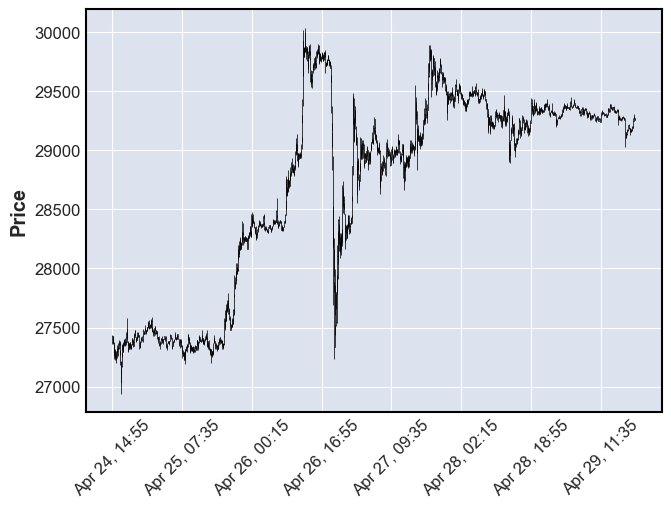

In [4]:
mpf.plot(dfmpl,type="ohlc",warn_too_much_data=2000)

In [5]:
sel = (df.high<df.high.rolling(10).max()*1.02) & (df.low> df.high.rolling(10).min()*0.98)
sel = (sel.rolling(10).sum()==10)
high= df.high.rolling(10).max()[sel]
low = df.low.rolling(10).min()[sel]

In [6]:
lastSlice=-500
alines = []    

In [7]:
import numpy as np

def get_consecutive_true_indices(arr): 
    if type(arr) != np.ndarray:
        arr = np.array(arr) 
    arr = np.concatenate([[False], arr, [False]]) 
    diffs = np.diff(arr.astype(int)) 
    starts = np.where(diffs == 1)[0]
    ends = np.where(diffs == -1)[0] - 1 
    return list(zip(starts, ends))

arr = np.array([False, True, True, False, True, True, True, False, False, True])
print(get_consecutive_true_indices(arr))


[(1, 2), (4, 6), (9, 9)]


In [8]:
sel.iloc[lastSlice:][5:15]

557842    True
557843    True
557844    True
557845    True
557846    True
557847    True
557848    True
557849    True
557850    True
557851    True
dtype: bool

In [9]:
get_consecutive_true_indices(sel.iloc[lastSlice:])

[(0, 499)]

In [10]:
dates = [ (d,h) for d,h,l,s in zip(dfmpl.index,dfmpl.High,dfmpl.Low,sel.iloc[lastSlice:]) if s]

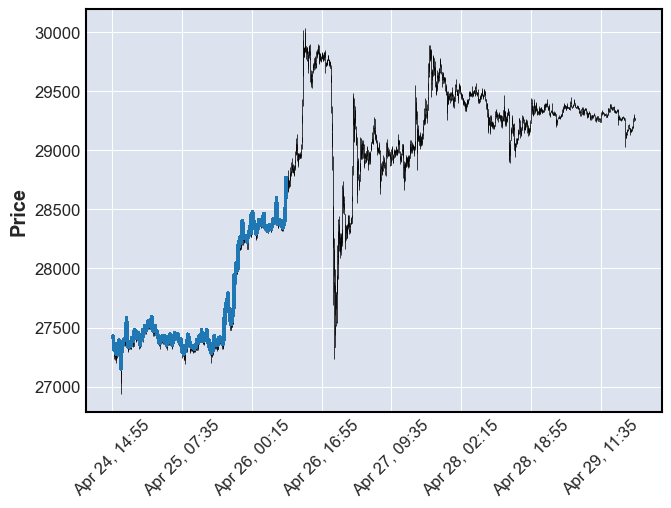

In [11]:
mpf.plot(dfmpl,alines=[dates],warn_too_much_data=2000)

In [12]:
def find_consolidation_regions(kline_df, window=15, threshold=0.02):
    """
    kline_df: DataFrame with 'High', 'Low' prices.
    window: Number of periods to consider for consolidation detection.
    threshold: Maximum allowed relative difference in price in consolidation.
    """
    # High / Low price
    high = kline_df['High']
    low = kline_df['Low']

    # Compute the relative difference
    #rel_diff = (high - low) / ((high + low) / 2)
    
    # Find periods of consolidation
    #consolidation = rel_diff.rolling(window).max() < threshold
    
    dh = kline_df['High']
    dl = kline_df['Low']
    consolidation = (dh<dh.rolling(window).max()*(1+threshold)) & (dl> dl.rolling(window).min()*(1-threshold))
    
    #print(consolidation)
    # Convert to numpy array for index calculation
    consolidation = np.array(consolidation)
    
    # Compute the differences between successive elements
    arr = np.concatenate([[False], consolidation, [False]])
    diffs = np.diff(arr.astype(int)) 
    # Get start and end indices
    starts = np.where(diffs == 1)[0]
    ends = np.where(diffs == -1)[0] - 1
    #print(starts,ends)
    return list(zip(starts, ends))

In [13]:
dfmpl.index[14]

Timestamp('2023-04-24 16:05:00')

In [14]:
window = dfmpl.iloc[15:30]

In [15]:
threshold=0.01
min_touches = 2
max_touches = 4
near_limit = 4
window_size=15

window = dfmpl.iloc[15:15+window_size]
def is_consolidation(window,
                    threshold=0.01,
min_touches = 2,
max_touches = 4,
near_limit = 4,
window_size=15):
    touch_resistance = window.High > (window.High.max()*(1-threshold))
    if sum(touch_resistance)< min_touches or sum(touch_resistance)> max_touches :
        return False
    touch_support = window.Low > (window.Low.max()*(1-threshold))
    if sum(touch_support)< min_touches or sum(touch_support)> max_touches :
        return False
    touches1 = np.where(touch_resistance)[0]
    touches2 = np.where(touch_support)[0]
    if touches1[0]>near_limit and touches1[-1]< (window_size-near_limit):
        if touches2[0]>near_limit and touches2[-1]< (window_size-near_limit):
            return False # should be close to start or end
    return True


In [16]:
%%time
indexes=[]
#previ = 0
for i in range(500-window_size):
    window = dfmpl.iloc[i:i+window_size]
    if is_consolidation(window):
        #print(i)
        #if previ +1 != i:
        indexes.append(i)
        #    previ = i
indexes = np.asarray(indexes)[np.where(np.diff(np.concatenate([[0],np.asarray(indexes)]))>1)[0]]

CPU times: total: 46.9 ms
Wall time: 191 ms


In [17]:
indexes

array([], dtype=float64)

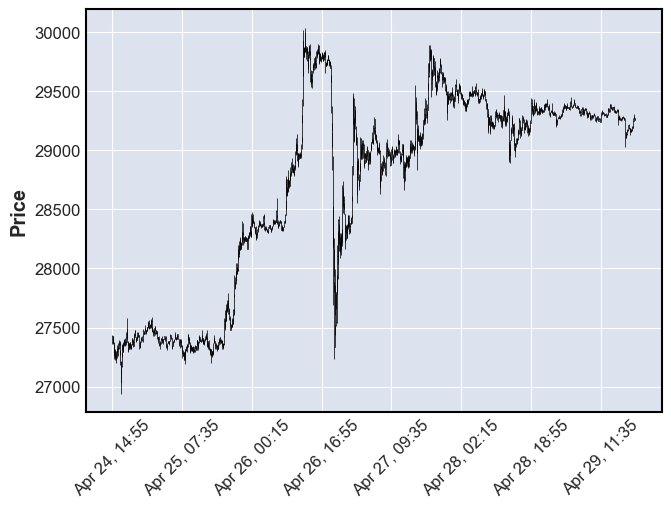

In [18]:
dates = []
colors=[]
for start in indexes:
    end = start+window_size
    high = dfmpl.iloc[start:end].High.max()
    low = dfmpl.iloc[start:end].Low.min()
    dates.append(((dfmpl.index[start],high),(dfmpl.index[end],high)))
    dates.append(((dfmpl.index[start],low),(dfmpl.index[end],low)))
    colors.append("g")
    colors.append("r")
mpf.plot(dfmpl,alines=dict(alines=dates,colors=colors),warn_too_much_data=2000)

# using TA lib

In [19]:
np.diff((ta.RSI(dfmpl.Close)>50)*1,1)[12:30]

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0])

In [20]:
np.diff((ta.RSI(dfmpl.Close)>50),1)[12:30]

array([False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False,  True, False])

In [21]:
crossings = np.where(np.diff(ta.RSI(dfmpl.Close)>50,1))[0]
scatter = [ dfmpl.Close.iloc[i]*1.02 if i in crossings else np.nan for i in np.arange(len(dfmpl.Close))]
vlines = [dfmpl.index[i] for i in np.arange(len(dfmpl.Close)) if i in crossings ]
my_vlines=[i for i in np.arange(len(dfmpl.Close)) if i in crossings ]

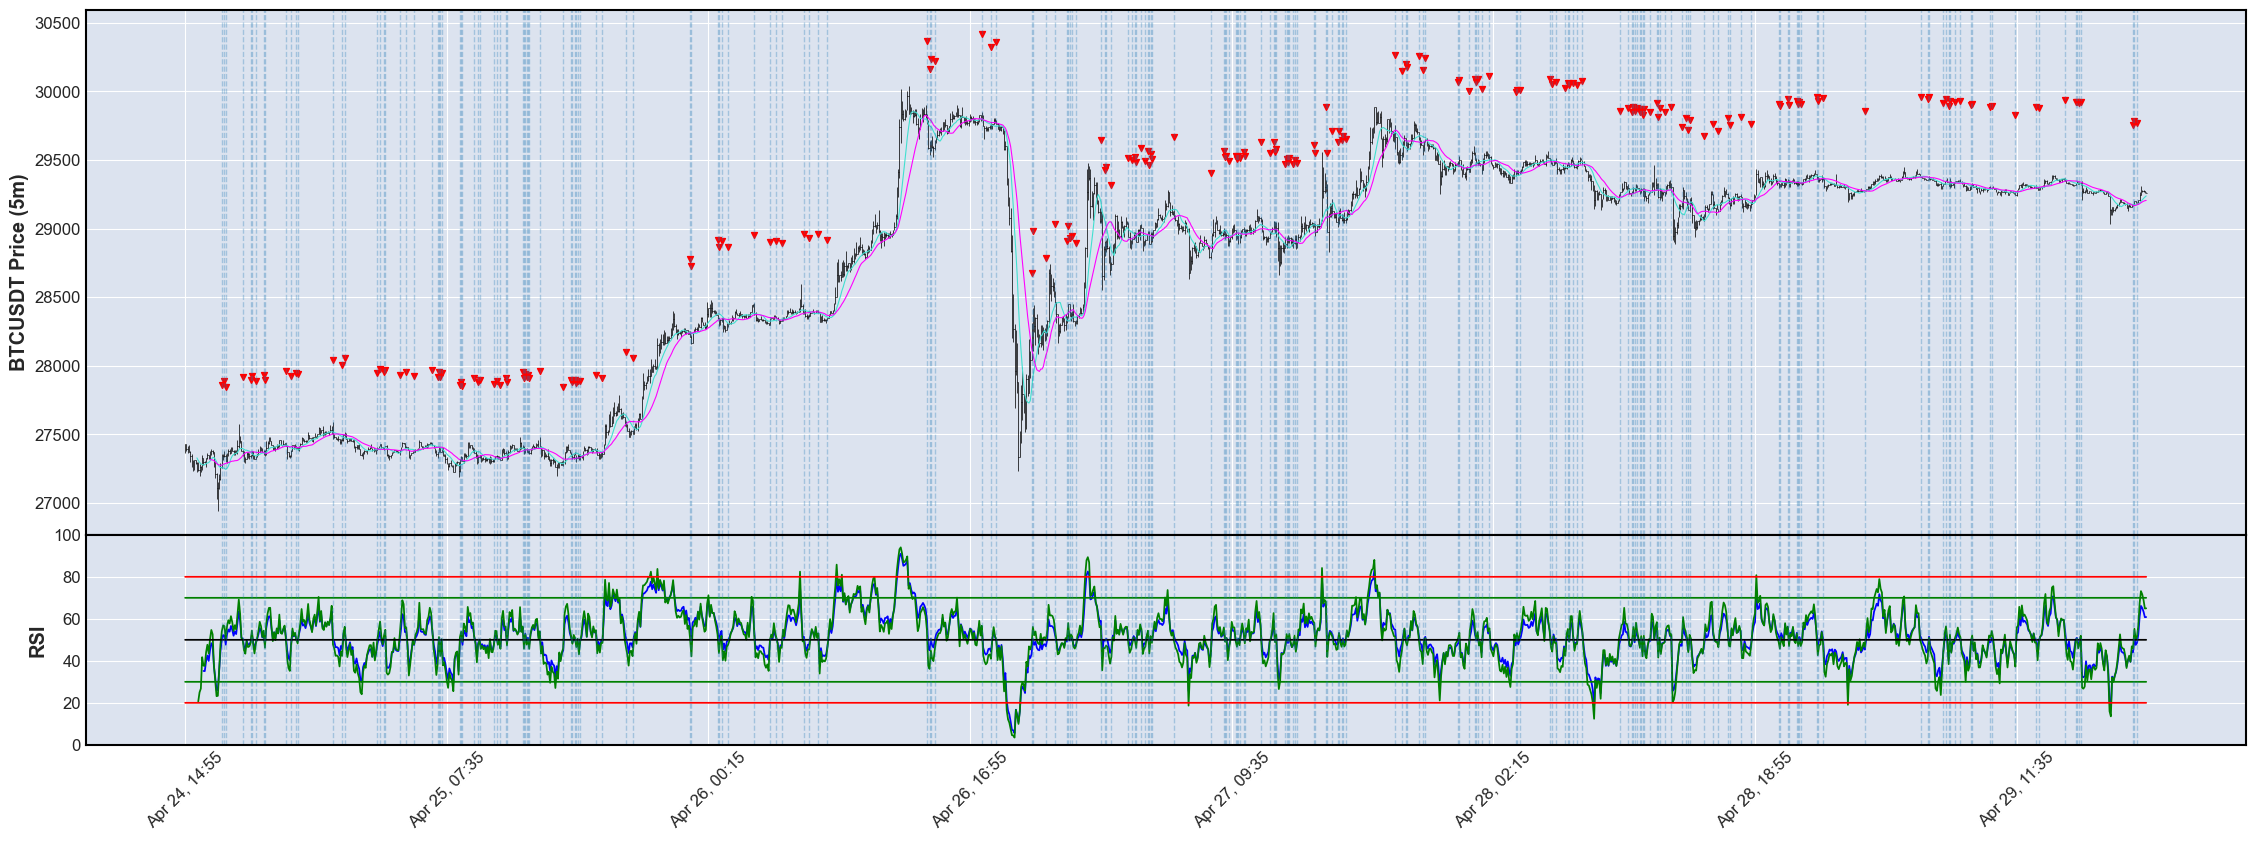

In [22]:
RSI_close = ta.RSI(dfmpl.Close)
RSI_close10 = ta.RSI(dfmpl.Close,10)
apds = [ #mpf.make_addplot(slo,type='scatter',markersize=200,marker='^'),
    mpf.make_addplot(RSI_close,panel=1,color='b',type='line',ylim=(0,100),ylabel="RSI"),
    mpf.make_addplot(RSI_close10,panel=1,color='g',type='line',ylim=(0,100),secondary_y=False),
    mpf.make_addplot(dfmpl.Close*0+70,panel=1,color='g',type='line', secondary_y=False),
    mpf.make_addplot(dfmpl.Close*0+30,panel=1,color='g',type='line', secondary_y=False),
    mpf.make_addplot(dfmpl.Close*0+50,panel=1,color='k',type='line', secondary_y=False),
    mpf.make_addplot(dfmpl.Close*0+80,panel=1,color='r',type='line', secondary_y=False),
    mpf.make_addplot(dfmpl.Close*0+20,panel=1,color='r',type='line', secondary_y=False),
    mpf.make_addplot(scatter,color='r',type='scatter',marker="v"),
    #mpf.make_addplot(vlines,color='r',type='vline'),
       ]
fig, axlist =mpf.plot(dfmpl,addplot=apds,ylabel=f"{tickerpair} Price ({interval})",mav=[10,20],
        #vlines=dict(vlines=vlines,linewidths=0.01,alpha=0.3,colors="r"),
         returnfig=True,figsize=(20*1.5,7*1.5),warn_too_much_data=2000)
for ax in axlist[:]:
    for vline in my_vlines:
        ax.axvline(x=vline, linestyle='--',linewidth=1,alpha=0.3)
mpf.show()

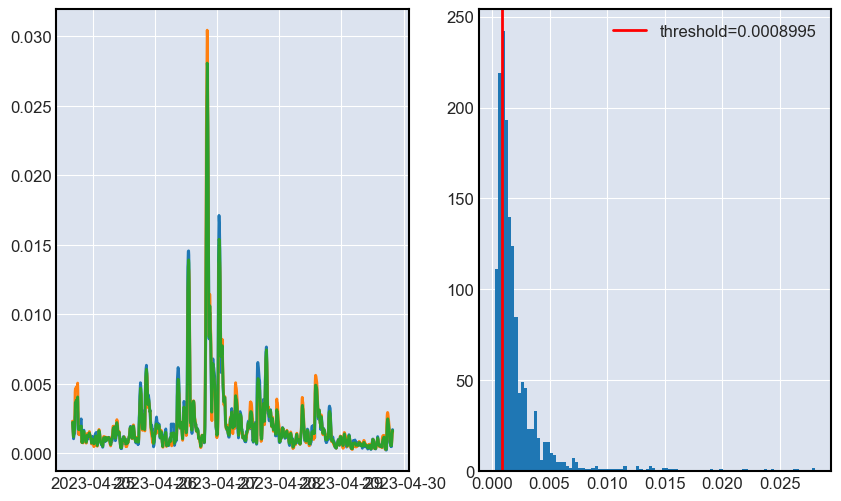

In [30]:
xvals=np.arange(len(dfmpl.Close))
rolling_high_std_mean = dfmpl.High.rolling(14).std()/dfmpl.High.rolling(14).mean()
rolling_low_std_mean = dfmpl.Low.rolling(14).std()/dfmpl.Low.rolling(14).mean()
rolling_std_mean=rolling_low_std_mean*0.5+rolling_high_std_mean*0.5
fig,(ax1,ax2)=plt.subplots(1,2,figsize=(10,6))
ax1.plot(rolling_high_std_mean)
ax1.plot(rolling_low_std_mean)
ax1.plot(rolling_std_mean)
n,bins,_ = ax2.hist(rolling_std_mean,bins=100)
thres = np.percentile(rolling_std_mean.values[np.where(~np.isnan(rolling_std_mean.values))],25)
ax2.axvline(thres,c="r",label=f"threshold={thres:.4g}")
ax2.legend()
#thres = 0.001
mkoffset = 1.01
crossings = np.where(np.diff(rolling_std_mean<thres,1))[0]
scatter = [ dfmpl.Close.iloc[i]*mkoffset if i in crossings else np.nan for i in xvals]
crossup=np.where(np.diff((rolling_std_mean<thres)*1.,1)<0)[0]
scatterup = [ dfmpl.Close.iloc[i]*mkoffset if i in crossup else np.nan for i in xvals]
crossdn=np.where(np.diff((rolling_std_mean<thres)*1.,1)>0)[0]
scatterdn = [ dfmpl.Close.iloc[i]*mkoffset if i in crossdn else np.nan for i in xvals]
vlines = [dfmpl.index[i] for i in xvals if i in crossings ]
my_vlines=[i for i in xvals if i in crossings ]

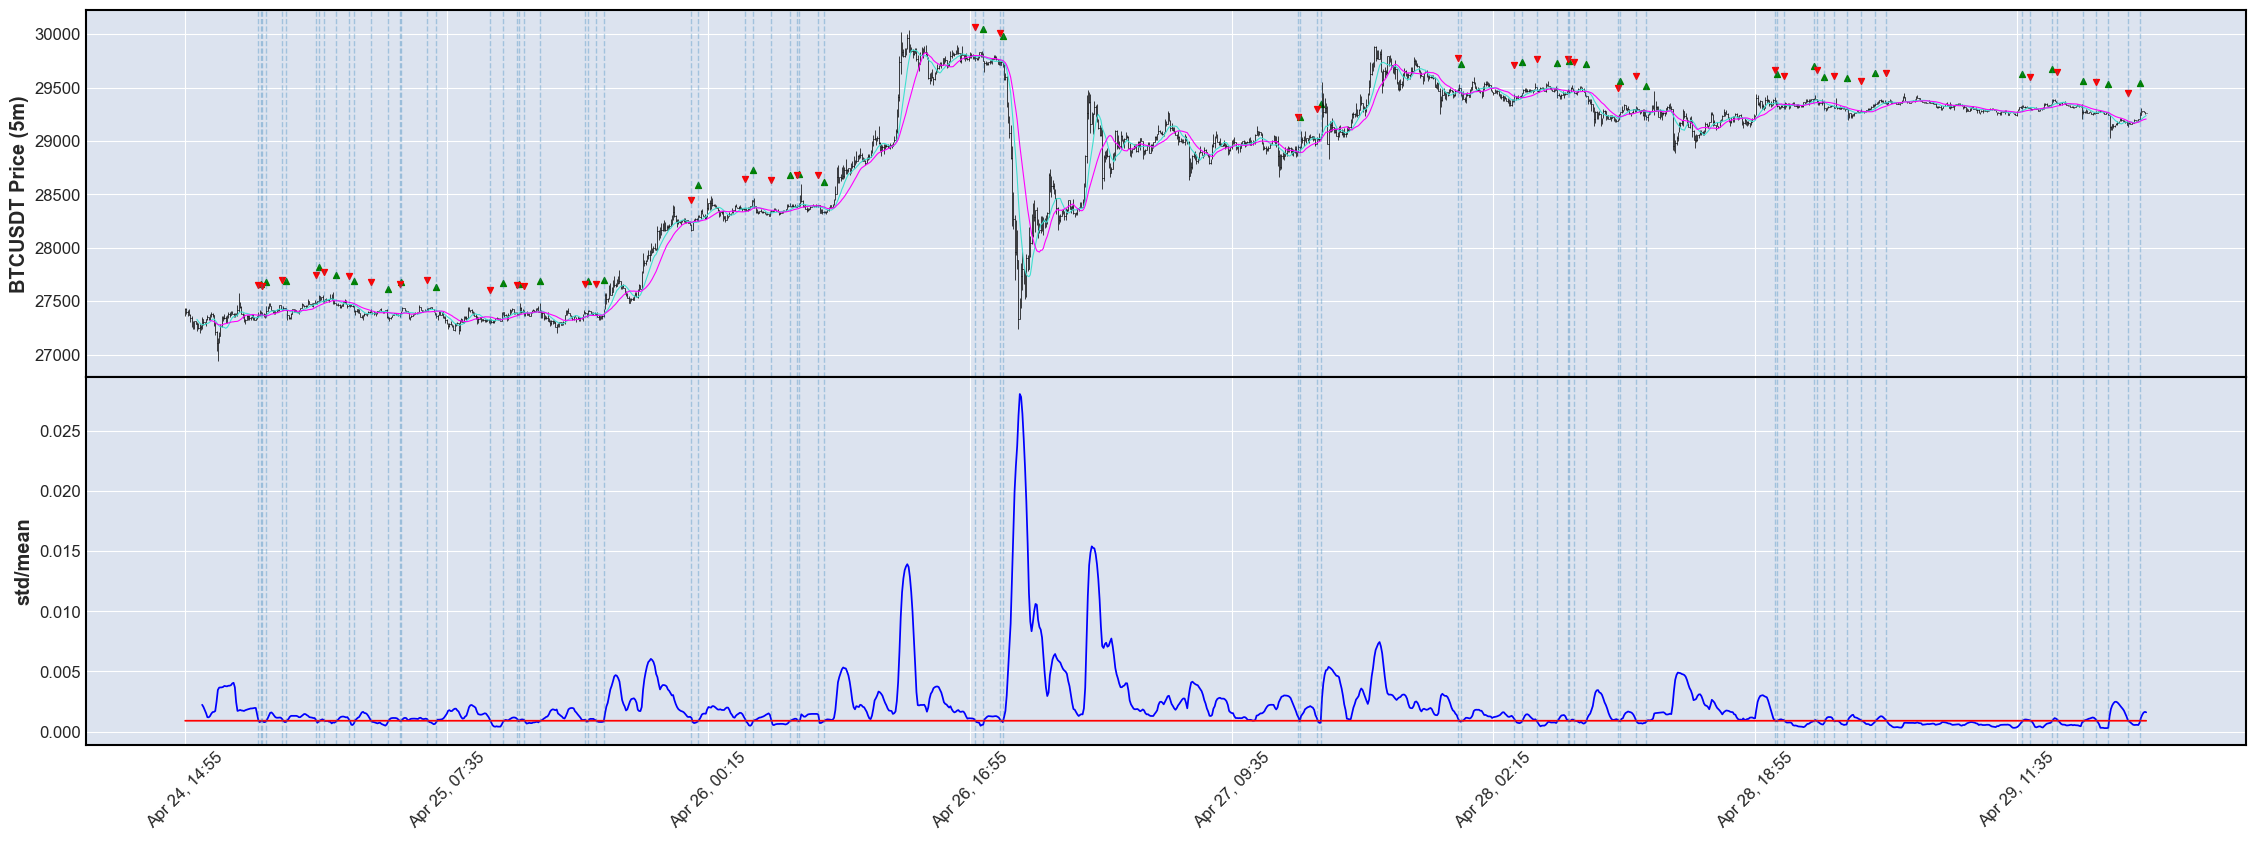

CPU times: total: 578 ms
Wall time: 1.04 s


In [31]:
%%time
apds = [ #mpf.make_addplot(slo,type='scatter',markersize=200,marker='^'),
    mpf.make_addplot(rolling_std_mean,panel=1,color='b',type='line',ylabel="std/mean"),
    mpf.make_addplot(dfmpl.Close*0+thres,panel=1,color='r',type='line', secondary_y=False),
    mpf.make_addplot(scatterup,color='g',type='scatter',marker="^"),
    mpf.make_addplot(scatterdn,color='r',type='scatter',marker="v"),
       ]
fig, axlist =mpf.plot(dfmpl,addplot=apds,ylabel=f"{tickerpair} Price ({interval})",mav=[10,20], 
         returnfig=True,figsize=(20*1.5,7*1.5),panel_ratios=(1,1),warn_too_much_data=2000)#,figratio=(1,1),figscale=1.5)
for ax in axlist[:]:
    for vline in my_vlines:
        ax.axvline(x=vline, linestyle='--',linewidth=1,alpha=0.3)
mpf.show()

# use the gradient of the std/mean instead

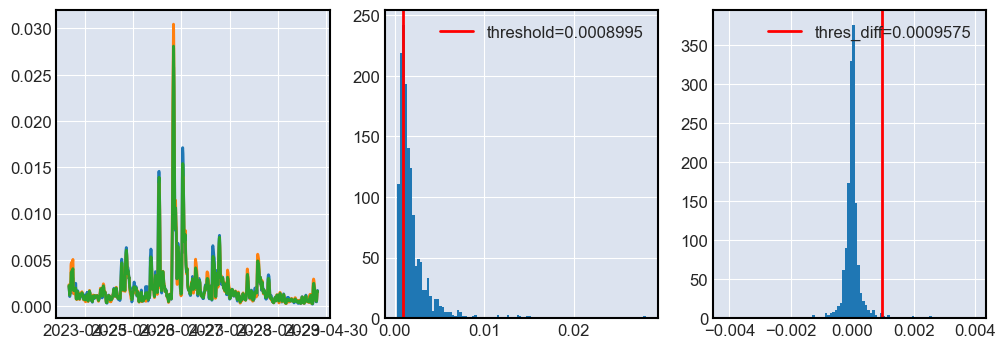

In [54]:
xvals=np.arange(len(dfmpl.Close))
rolling_high_std_mean = dfmpl.High.rolling(14).std()/dfmpl.High.rolling(14).mean()
rolling_low_std_mean = dfmpl.Low.rolling(14).std()/dfmpl.Low.rolling(14).mean()
rolling_std_mean=rolling_low_std_mean*0.5+rolling_high_std_mean*0.5
r_std_mean_diff = rolling_std_mean.diff()

fig,(ax1,ax2,ax3)=plt.subplots(1,3,figsize=(12,4))
ax1.plot(rolling_high_std_mean)
ax1.plot(rolling_low_std_mean)
ax1.plot(rolling_std_mean)
n,bins,_ = ax2.hist(rolling_std_mean,bins=100)
thres = np.percentile(rolling_std_mean.values[np.where(~np.isnan(rolling_std_mean.values))],25)
ax2.axvline(thres,c="r",label=f"threshold={thres:.4g}")
ax2.legend()
ax3.hist(r_std_mean_diff,bins=100)
thres_diff = np.percentile(r_std_mean_diff.values[np.where(~np.isnan(r_std_mean_diff.values))],98)
ax3.axvline(thres_diff,c="r",label=f"thres_diff={thres_diff:.4g}")
ax3.legend()
#thres = 0.001
mkoffset = 1.01
crossings = np.where(np.diff(r_std_mean_diff>thres_diff,1))[0]
scatter = [ dfmpl.Close.iloc[i]*mkoffset if i in crossings else np.nan for i in xvals]
crossup=np.where(np.diff((r_std_mean_diff>thres_diff)*1.,1)>0)[0]
scatterup = [ dfmpl.Close.iloc[i]*mkoffset if i in crossup else np.nan for i in xvals]
crossdn=np.where(np.diff((r_std_mean_diff>thres_diff)*1.,1)<0)[0]
scatterdn = [ dfmpl.Close.iloc[i]*mkoffset if i in crossdn else np.nan for i in xvals]
vlines = [dfmpl.index[i] for i in xvals if i in crossings ]
my_vlines=[i for i in xvals if i in crossings ]

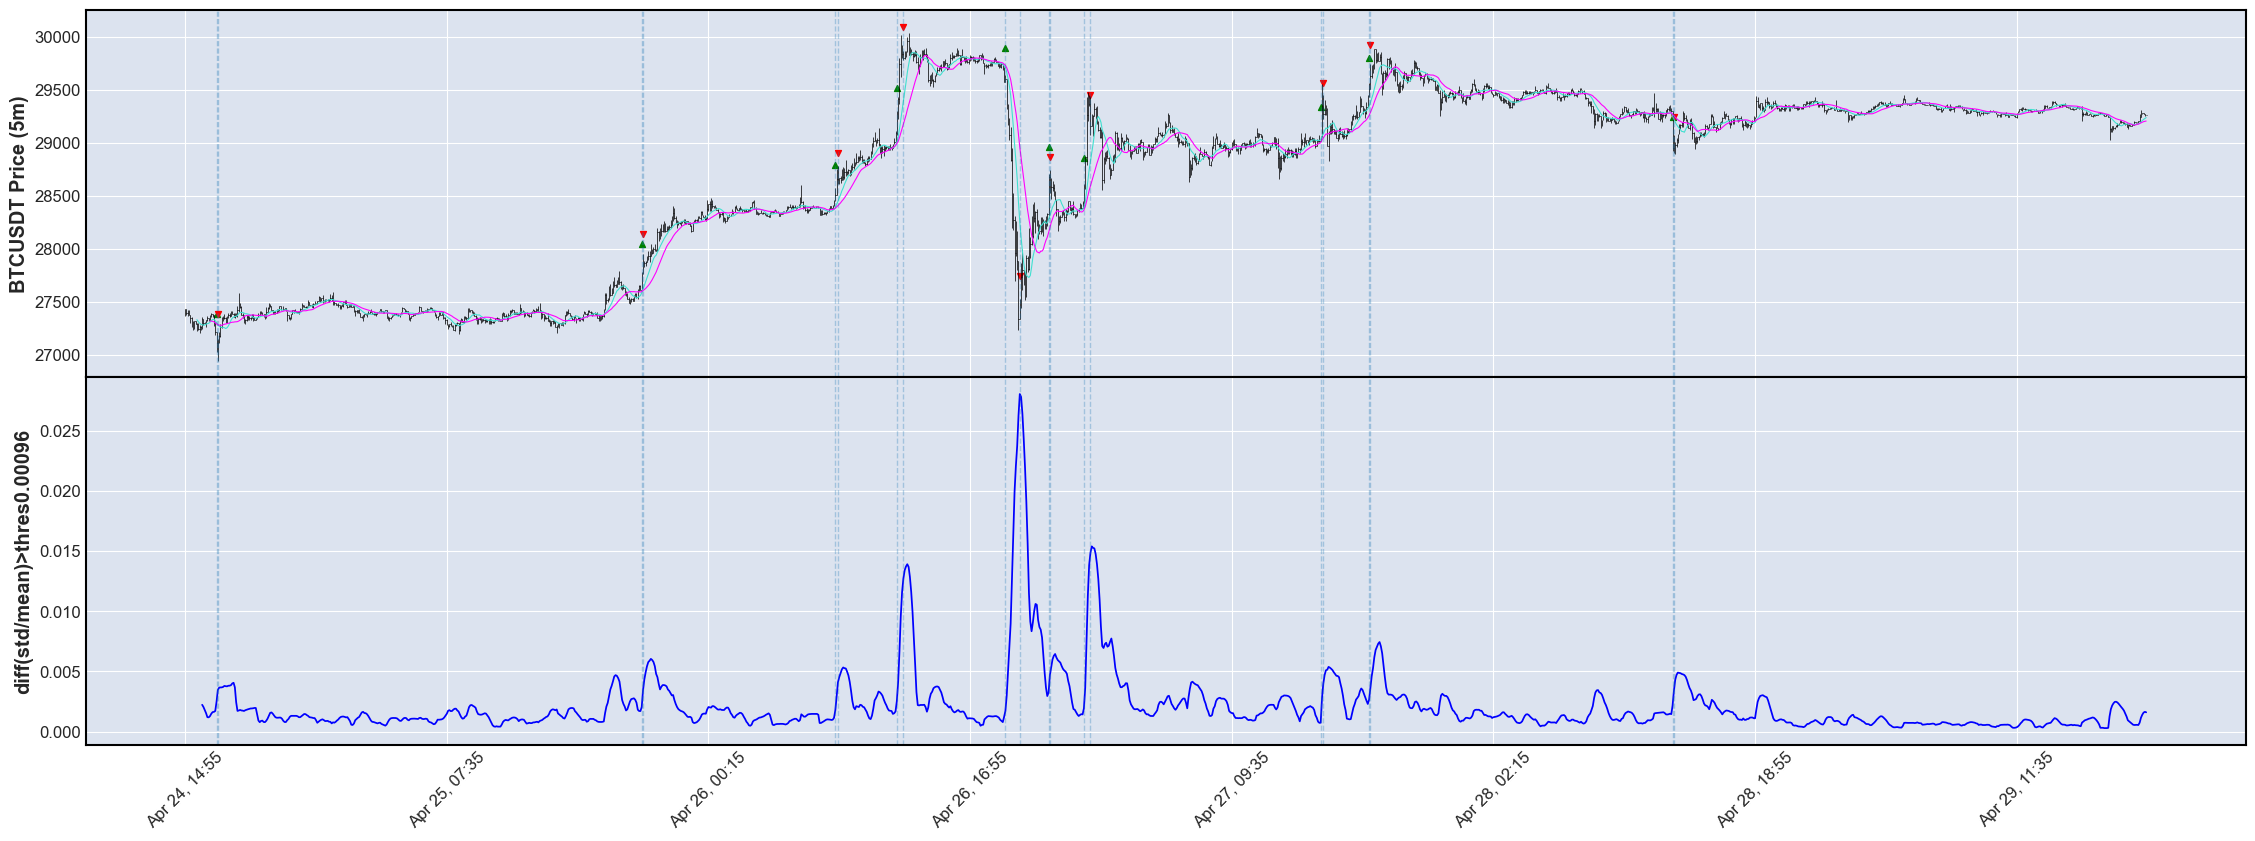

CPU times: total: 562 ms
Wall time: 826 ms


In [55]:
%%time
apds = [ #mpf.make_addplot(slo,type='scatter',markersize=200,marker='^'),
    mpf.make_addplot(rolling_std_mean,panel=1,color='b',type='line',ylabel=f"diff(std/mean)>thres{thres_diff:.2g}"),
    #mpf.make_addplot(dfmpl.Close*0+thres,panel=1,color='r',type='line', secondary_y=False),
    mpf.make_addplot(scatterup,color='g',type='scatter',marker="^"),
    mpf.make_addplot(scatterdn,color='r',type='scatter',marker="v"),
       ]
fig, axlist =mpf.plot(dfmpl,addplot=apds,ylabel=f"{tickerpair} Price ({interval})",mav=[10,20], 
         returnfig=True,figsize=(20*1.5,7*1.5),panel_ratios=(1,1),warn_too_much_data=2000)#,figratio=(1,1),figscale=1.5)
for ax in axlist[:]:
    for vline in my_vlines:
        ax.axvline(x=vline, linestyle='--',linewidth=1,alpha=0.3)
mpf.show()

In [78]:
predict = []
result= []
for entry,exit in zip(np.where(~np.isnan(scatterup))[0],np.where(~np.isnan(scatterdn))[0]):
    print(entry,exit)
    print(dfmpl.iloc[entry-1:exit+1])
    s = dfmpl.iloc[entry-1]
    s2 = dfmpl.iloc[exit]
    predict.append( s.Open-s.Close )
    result.append( s.Close-s2.Close )
    print("*"*8,s.Close,s2.Close)

24 25
                         Open      High       Low     Close      Volume
Date                                                                   
2023-04-24 16:50:00  27280.91  27307.77  27183.28  27211.73   592.64412
2023-04-24 16:55:00  27211.73  27216.43  27028.64  27110.55  1360.08980
2023-04-24 17:00:00  27110.56  27150.95  26942.82  27111.63  1330.07121
******** 27211.73 27111.63
349 350
                         Open      High       Low     Close      Volume
Date                                                                   
2023-04-25 19:55:00  27650.80  27655.56  27610.72  27611.40   142.67404
2023-04-25 20:00:00  27611.39  27783.08  27611.01  27762.41   554.97797
2023-04-25 20:05:00  27762.41  27948.03  27761.32  27860.01  1044.54590
******** 27611.4 27860.01
497 499
                         Open      High       Low     Close      Volume
Date                                                                   
2023-04-26 08:15:00  28402.37  28459.29  28402.36  28449.34  

Text(0, 0.5, 'actual')

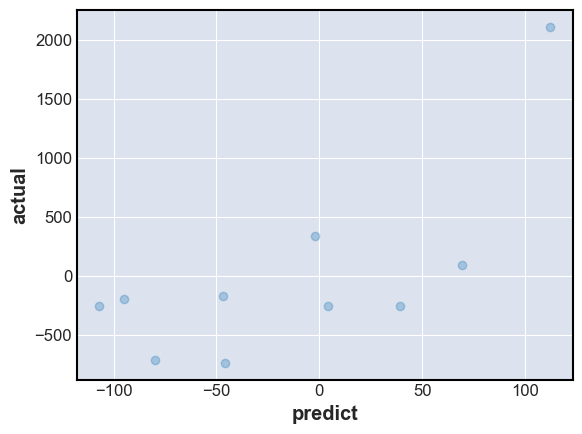

In [81]:
plt.scatter(predict,result,alpha=0.3)
plt.xlabel("predict")
plt.ylabel("actual")

In [82]:
np.sign(predict)

array([ 1.,  1., -1., -1.,  1., -1., -1.,  1., -1., -1.])

In [84]:
np.sign(result)

array([ 1., -1., -1., -1.,  1., -1., -1., -1., -1.,  1.])

In [85]:
from sklearn.metrics import confusion_matrix
confusion_matrix(np.sign(result), np.sign(predict))

array([[5, 2],
       [1, 2]], dtype=int64)

In [86]:
from sklearn.metrics import ConfusionMatrixDisplay

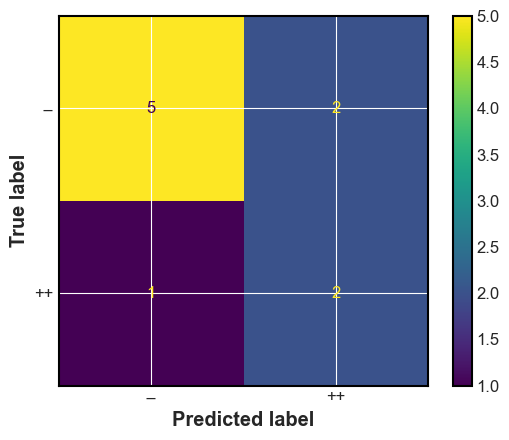

In [88]:
ConfusionMatrixDisplay.from_predictions( 
        np.sign(result),
        np.sign(predict),
        display_labels=["--","++"])